# multstars Tutorial

### Multstars is a statistical analysis package for Python. With multstars, you can determine the parameters governing the underlying distributions of projected physical separations and mass ratios for observed contrasts and angular separations of stellar multiples.

The separations are modeled as a log normal distribution, and the mass ratios as a power law.

This gives three parameters to fit:
- center: the center of the log normal separation distribution
- width: the width of the underlying separation distribution
- power index: of the mass ratio power law

First we'll import the required functions and data

In [1]:
# import the model
import multstars
from multstars.data_io import get_example_data_file_path, load_data
from multstars.model import pymc3_hrchl_fit

# additional imports for plotting
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as st

%matplotlib inline

In [2]:
data_path = get_example_data_file_path('hm_data_test.txt')
data = load_data(data_path)
data[:5]

,Unnamed: 0,asep,asep_err,cr,cr_err,parallax
0,2,1.589981,0.07,3.461969,0.019347,0.011365
1,3,0.938303,0.07,0.247226,0.000841,0.044507
2,4,1.553004,0.07,1.528500,0.011911,0.024812
3,9,0.350454,0.07,1.480197,0.085754,0.009677
4,10,0.744162,0.07,0.560127,0.050180,0.043209


Here are the main measurements we will use to fit our model:

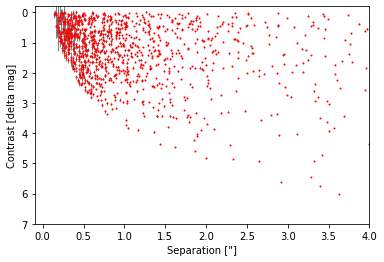

In [3]:
plt.errorbar(data['asep'], data['cr'], yerr=data['cr_err'], 
             marker='.', mec='r', ms=2, ls='none', linewidth=1, ecolor='grey')
plt.ylim(7, -0.2); plt.xlim(-0.1, 4)
plt.xlabel('Separation ["]'); plt.ylabel('Contrast [delta mag]');

However, we want to determine parameters on physical characteristics - mass ratios and phsyical separations, not contrast ratios and angular separations. There are several transformations which need to be done to transform between these and account for observation limitations. Therefore, we will use a hierarchical model. To see the transformations used in this hierarchical model, see `hierarchical_model_steps.ipynb`. 

Running the hierarchical model:

In [4]:
ta = time.time()
samples = pymc3_hrchl_fit(data, nsteps=1000)
tb = time.time()
print('Fit finished, took ',round((tb-ta)/60., 1),' minutes' )

C:\Users\Claire\Anaconda3\lib\site-packages\pymc3\distributions\continuous.py:88: UserWarning: The variable specified for alpha has negative support for Pareto, likely making it unsuitable for this parameter.
  warnings.warn(msg)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mass_ratios_inverted, sep_physical, power_index, center, width]
Sampling chain 0, 4 divergences: 100%|████| 2000/2000 [00:10<00:00, 185.56it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Fit finished, took  0.5  minutes


...and looking at results

In [5]:
# estimate of the MAP
q = samples.quantile([0.16,0.50,0.84], axis=0)
c_lower, c, c_upper = q['center']
w_lower, w, w_upper = q['width']

p_lower, p, p_upper = q['power_index']

Parameters for Gamma distribution describing the separations:

center = 3.41 + 0.89 - 0.85
width = 1.0 + 0.6 - 0.4


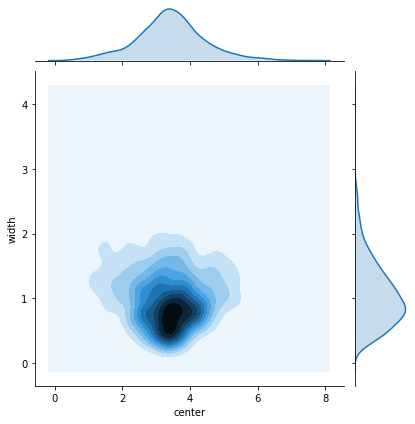

In [6]:
sns.jointplot(x='center', y='width', data=samples, kind='kde');

print("center = {:.2f} + {:.2f} - {:.2f}".format(c, c_upper-c, c-c_lower))
print("width = {:.1f} + {:.1f} - {:.1f}".format(w, w_upper-w, w-w_lower))

The power-law index describing the mass ratio distribution:

Power law index = 1.23 + 0.19 - 0.21


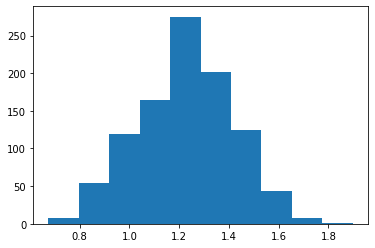

In [7]:
plt.hist(samples['power_index'])

print("Power law index = {:.2f} + {:.2f} - {:.2f}".format(p, p_upper-p, p-p_lower))

## Comparing to Original Population

The test data we just fit was generated in `hierarchical_model_steps.ipynb`. Let's compare our fit to the original population and the distibutions used to simulate them.

In [8]:
# original population
op_path = get_example_data_file_path('test_op0.txt')
op = load_data(op_path)

In [12]:
# functions to plot
def plot_lognorm(mu, sigma, data, bins, label):
    xs = np.linspace(0, np.max(data), 10000)
    pdfn = st.lognorm.pdf(xs, sigma, scale=np.exp(mu))
    normedy = len(data)*np.diff(bins)[0]*pdfn
    plt.plot(xs, normedy, label=label)
    
def plot_power_law(index, data, bins, label):
    xs = np.linspace(0, np.max(data), 100)
    ys = index*xs**(index-1.)
    normed_y = len(data)*np.diff(bins)[0]*ys
    plt.plot(xs, normed_y, label=label);

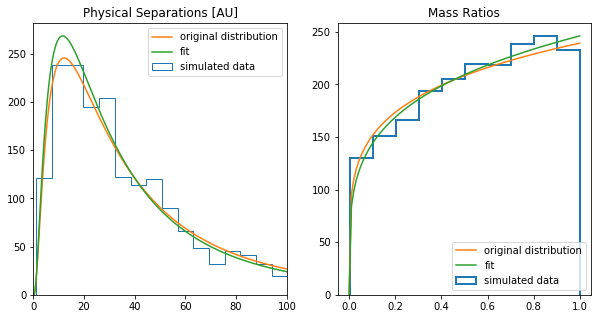

In [14]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Physical Separations [AU]')
count, bns, ignored = plt.hist(op['sep_physical'], histtype='step', label='simulated data', bins=100, linewidth=1)
plot_lognorm(3.5, 1, op['sep_physical'], bns, 'original distribution')
plot_lognorm(c, w, op['sep_physical'], bns, 'fit')
plt.xlim(0, 100)
plt.legend();

plt.subplot(122)
plt.title('Mass Ratios')
count, bns, ignored = plt.hist(op['mass_ratio'], histtype='step', label='simulated data', bins=10, linewidth=2)
plot_power_law(1.2, op['mass_ratio'], bns, 'original distribution')
plot_power_law(p, op['mass_ratio'], bns, 'fit')
plt.legend(loc='lower right');